#### 基本設置 + 設cuda

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 16
num_classes = 4
learning_rate = 0.002
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 讀取資料集

In [2]:
import torchvision.datasets as dset

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((128, 480)),  # 将图像调整为指定大小
    transforms.ToTensor(),           # 将图像转换为张量
])

# 加載圖像數據集，並只考慮指定的資料夾
# dataset = dset.ImageFolder(root='./Merge_Dataset/train', transform=transform)
dataset = dset.ImageFolder(root='./dataset_v2/train', transform=transform)


# 獲取相關信息
print(dataset.classes)  # 根據分的文件夾的名字來確定類別
print(dataset.class_to_idx)  # 按順序為這些類別定義索引為 0, 1, ...
print(len(dataset))  # 返回數據集的大小

print(dataset[0][0].size())  # 返回第一張圖片的大小

['boat', 'dolphin', 'fish', 'whale']
{'boat': 0, 'dolphin': 1, 'fish': 2, 'whale': 3}
102
torch.Size([3, 128, 480])


In [3]:
from torch.utils.data import DataLoader

# 加載圖像數據集，並只考慮指定的資料夾
train_dataset = dset.ImageFolder(root='./dataset_v2/train', transform=transform)
test_dataset = dset.ImageFolder(root='./dataset_v2/test', transform=transform)

# 创建 DataLoader 对象
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))

7
3


#### 創立model

In [4]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,128,480)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=25, kernel_size=3, stride=1, padding=0) #output_shape=(25,126,478)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(25,63,239)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=25, out_channels=32, kernel_size=6, stride=1, padding=0) #output_shape=(32,58,234)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,29,117)
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=1, padding=0) #output_shape=(32,26,114)
        self.relu3 = nn.ReLU() # activation
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,13,57)
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=1, padding=0) #output_shape=(32,26,114)
        self.relu4 = nn.ReLU() # activation
        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,6,28)
        # Fully connected 1 ,#input_shape=(32*13*57)
        self.fc1 = nn.Linear(32 * 6 * 28, 1024) 
        # Fully connected 2
        self.fc2 = nn.Linear(1024, 32)
        # Fully connected 3
        self.fc3 = nn.Linear(32, 4)
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        # Max pool 1
        out = self.maxpool1(out)
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        # Max pool 2
        out = self.maxpool2(out)
        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)
        # Max pool 3
        out = self.maxpool3(out)
        # Convolution 4
        out = self.cnn4(out)
        out = self.relu4(out)
        # Max pool 4
        out = self.maxpool4(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [5]:
import torchinfo
import torchinfo

model = CNN_Model()
print(f"Model's structure:\n {torchinfo.summary(model)}")

Model's structure:
Layer (type:depth-idx)                   Param #
CNN_Model                                --
├─Conv2d: 1-1                            700
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            28,832
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            16,416
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           4,128
├─ReLU: 1-11                             --
├─MaxPool2d: 1-12                        --
├─Linear: 1-13                           5,506,048
├─Linear: 1-14                           32,800
├─Linear: 1-15                           132
Total params: 5,589,056
Trainable params: 5,589,056
Non-trainable params: 0


#### 訓練模型

In [6]:
import time
# Move model to "device".
model = model.to(device)
# File name.
modelSaveName = "MyModel_v2.pt"
# Create an optimizer.
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.CrossEntropyLoss()

bestValidAcc = 0
for epoch in range(1, num_epochs+1):
  start_time = time.time()  # 計算每個epoch開始的時間
  # Training mode.
  model.train()
  train_loss = 0.0
  for iter, (input, target) in enumerate(train_loader):
    # Move data to "device".
    input = input.to(device)
    target = target.to(device)
    # Clear optimizer gradients.
    optimizer.zero_grad()
    
    # Forward pass.
    output = model(input)
    # Compute the loss.
    loss=lossFunc(output, target)
    # Loss backward propagation.
    loss.backward()
    # Update all learnable parameters.
    optimizer.step()
    # update training loss
    train_loss += loss.item()

  # statistics
  # 計算每個樣本的平均損失
  train_loss = train_loss / len(train_loader.dataset)
  end_time = time.time()  # 計算每個epoch結束的時間
  epoch_time = end_time - start_time  # 計算每個epoch所花的時間
  print("Epoch:{}/{}, Time:{:.2f} seconds, Train Loss: {:.4f}".format(epoch, num_epochs, epoch_time, train_loss))

# 存檔
torch.save(model.state_dict(), modelSaveName, _use_new_zipfile_serialization=False)
print('Model saved to %s' % modelSaveName)

Epoch:1/20, Time:80.84 seconds, Train Loss: 0.1027
Epoch:2/20, Time:3.01 seconds, Train Loss: 0.0958
Epoch:3/20, Time:2.76 seconds, Train Loss: 0.0961
Epoch:4/20, Time:2.74 seconds, Train Loss: 0.0937
Epoch:5/20, Time:2.76 seconds, Train Loss: 0.0918
Epoch:6/20, Time:2.71 seconds, Train Loss: 0.0901
Epoch:7/20, Time:2.76 seconds, Train Loss: 0.0867
Epoch:8/20, Time:2.76 seconds, Train Loss: 0.0839
Epoch:9/20, Time:2.76 seconds, Train Loss: 0.0799
Epoch:10/20, Time:2.71 seconds, Train Loss: 0.0810
Epoch:11/20, Time:2.71 seconds, Train Loss: 0.0719
Epoch:12/20, Time:2.73 seconds, Train Loss: 0.0605
Epoch:13/20, Time:2.77 seconds, Train Loss: 0.0642
Epoch:14/20, Time:2.75 seconds, Train Loss: 0.0536
Epoch:15/20, Time:2.74 seconds, Train Loss: 0.0454
Epoch:16/20, Time:2.73 seconds, Train Loss: 0.0400
Epoch:17/20, Time:2.94 seconds, Train Loss: 0.0348
Epoch:18/20, Time:2.84 seconds, Train Loss: 0.0657
Epoch:19/20, Time:2.83 seconds, Train Loss: 0.0429
Epoch:20/20, Time:2.71 seconds, Train L

測試模型

In [7]:
model = CNN_Model()
model.load_state_dict(torch.load('MyModel_v2.pt'))

<All keys matched successfully>

In [8]:
correct = 0
total = 0
# 新增這邊記錄真實跟預測值
pred_list = []
label_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_list.extend(predicted.cpu().numpy())
        label_list.extend(labels.cpu().numpy())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

Accuracy of the network on the 37 test images: 78.37837837837837 %


印出一batch當中的每分類預測機率。

In [9]:
class_names = ['boat', 'dolphin', 'fish', 'whale']

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # use softmax to get the probability
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
         # 印出每張圖片的預測機率
        for i in range(len(probabilities)):
            print(f'Predicted probabilities for sample {i}:')

            # 印出每個類別的預測機率
            for j, class_name in enumerate(class_names):
                print(f'{class_name}: {probabilities[i][j].item():.4f}', end=', ')

            print()

        break

Predicted probabilities for sample 0:
boat: 1.0000, dolphin: 0.0000, fish: 0.0000, whale: 0.0000, 
Predicted probabilities for sample 1:
boat: 0.0000, dolphin: 1.0000, fish: 0.0000, whale: 0.0000, 
Predicted probabilities for sample 2:
boat: 0.9822, dolphin: 0.0106, fish: 0.0000, whale: 0.0072, 
Predicted probabilities for sample 3:
boat: 0.0008, dolphin: 0.9958, fish: 0.0000, whale: 0.0034, 
Predicted probabilities for sample 4:
boat: 1.0000, dolphin: 0.0000, fish: 0.0000, whale: 0.0000, 
Predicted probabilities for sample 5:
boat: 0.0000, dolphin: 0.9997, fish: 0.0000, whale: 0.0003, 
Predicted probabilities for sample 6:
boat: 0.9484, dolphin: 0.0382, fish: 0.0000, whale: 0.0133, 
Predicted probabilities for sample 7:
boat: 0.0146, dolphin: 0.9854, fish: 0.0000, whale: 0.0000, 
Predicted probabilities for sample 8:
boat: 1.0000, dolphin: 0.0000, fish: 0.0000, whale: 0.0000, 
Predicted probabilities for sample 9:
boat: 1.0000, dolphin: 0.0000, fish: 0.0000, whale: 0.0000, 
Predicted 

測試那些有海豚的船聲

In [10]:
from PIL import Image
imgPath = './dataset_v2/test/boat/denoise_20201017_221700.png'
img = Image.open(imgPath).convert('RGB')
img = transform(img)    # apply the transform to the image

img = img.unsqueeze(0)  # add a batch dimension [batch, channels, width, height]

with torch.no_grad():
    # calculate outputs by running images through the network
    outputs = model(img)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    print(f'Predicted class: {class_names[predicted.item()]}')

    # use softmax to get the probability
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    print(f'Predicted probabilities:')
    for j, class_name in enumerate(class_names):
        print(f'{class_name}: {probabilities[0][j].item():.4f}', end=', ')

Predicted class: dolphin
Predicted probabilities:
boat: 0.0000, dolphin: 0.9997, fish: 0.0000, whale: 0.0003, 

Confusion matrix

{'boat': 0, 'dolphin': 1, 'fish': 2, 'whale': 3}


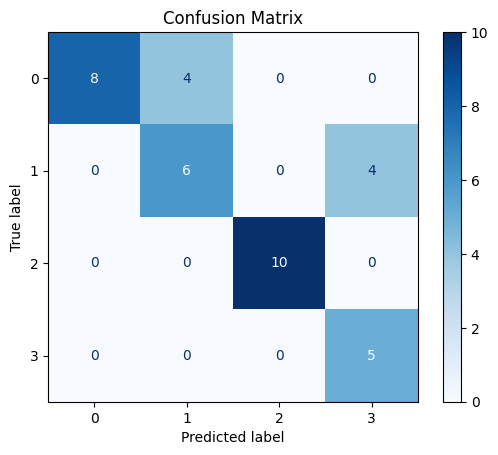

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 印出類別對應的索引
print(test_dataset.class_to_idx)  # 按順序為這些類別定義索引為 0, 1, ...

# 生成混淆矩阵
cm = confusion_matrix(label_list, pred_list)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(4))
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

Load best model

In [12]:
Bestmodel = CNN_Model()
Bestmodel.load_state_dict(torch.load('MyModel_v2_Best.pt'))
Bestmodel.eval()

CNN_Model(
  (cnn1): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(25, 32, kernel_size=(6, 6), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5376, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

In [13]:
correct = 0
total = 0
# 新增這邊記錄真實跟預測值
pred_list = []
label_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = Bestmodel(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pred_list.extend(predicted.cpu().numpy())
        label_list.extend(labels.cpu().numpy())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

Accuracy of the network on the 37 test images: 100.0 %


{'boat': 0, 'dolphin': 1, 'fish': 2, 'whale': 3}


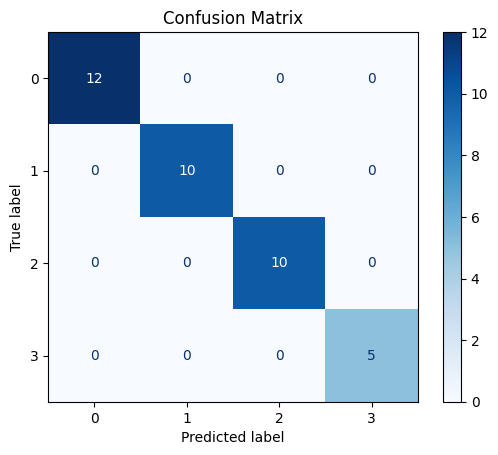

In [14]:
# 印出類別對應的索引
print(test_dataset.class_to_idx)  # 按順序為這些類別定義索引為 0, 1, ...

# 生成混淆矩阵
cm = confusion_matrix(label_list, pred_list)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(4))
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()